# Chapter 5: Neural Network IMDB
## Transfer Learning for NL Modelling. 
Transfer learning was only successful in 2017, beginning with ULMFit (built upon BERT and GPT-2). 

FOr language models, creative AI exploration can see [Janelle Shane Blogs](https://aiweirdness.com/). 

Language models requires decreasing batch size to fit onto the GPU. 

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.text.all import *
from utils import *
from scipy.spatial.distance import cosine as dist 

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path

In [4]:
bs = 96

torch.cuda.set_device(0)

if not os.path.exists("output"): os.mkdir("output")

In [5]:
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/"texts.csv")

imdb_clas = DataBlock(
    blocks=(TextBlock.from_df("text", seq_len=72), CategoryBlock),
    get_x=ColReader("text"), get_y=ColReader("label"), splitter=ColSplitter()
)

dls = imdb_clas.dataloaders(df, bs=bs)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


## Prepare the IMDB data (on a sample). 

In [6]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

(#1) [Path('/home/fastai2/.fastai/data/imdb_sample/texts.csv')]

In [7]:
df = pd.read_csv(path/"texts.csv")

imdb_clas = DataBlock(
    blocks=(TextBlock.from_df("text", seq_len=72), CategoryBlock),
    get_x=ColReader("text"), get_y=ColReader("label"), splitter=ColSplitter()
)

dls = imdb_clas.dataloaders(df, bs=bs)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


### Tokenization
- We need to take care of punctuations
- Some words are contractions of two different words, like isn't and don't. 
- We may need to clean some parts of our texts, if there's HTML code for instance. 

It did more than splitting on space and punctuation symbols: 
- "s" are grouped together in one token. 
- contractions are separated like "did", "n't".
- content have been cleaned for any HTML symbol and lower cased. 
- There are several special tokens (all begin by xx) to replace unknown tokens or introduce different text fields (here we only have one).

### Numericalization
ONce we extract tokens from text, we convert to integers by creating a list of all words used. We only keep those that appear at least twice with max vocab size of 60k (default for previous fastai, now unsure) and replace those that don't make the cut by unknown token UNK (xxunk). We can see the vocabulary. 

In [8]:
dls.vocab.itemgot()[0][:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the']

In [9]:
# Trying to look in dataset, we see tokenized text as representation. 
str_list_to_par(dls, 0)

"xxbos xxmaj un - bleeping - believable ! xxmaj meg xxmaj ryan does n't even look her usual pert lovable self in this , which normally makes me forgive her shallow ticky acting schtick . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj whoosh … xxmaj banzai xxrep 3 ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj chill ? xxmaj must be a replay of xxmaj jonestown - hollywood style . w xxrep 3 o xxrep 3 f !"

In [10]:
itos(dls.vocab[0], dls.train_ds[0][0], join=True)

"xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk … xxmaj xxunk xxrep 3 ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . w xxrep 3 o xxrep 3 f !"

In [11]:
# Underlying data
dls.train_ds[0][0][:10]

TensorText([   2,    8, 4499,   24,    0,   24,  951,   54,    8, 4500])

## Transfer Learning
We will use pretrained weights from `wikitext-103` language model. We will use full IMDb Dataset. 

In [12]:
path = untar_data(URLs.IMDB)
path.ls(), (path/"train").ls()

((#7) [Path('/home/fastai2/.fastai/data/imdb/imdb.vocab'),Path('/home/fastai2/.fastai/data/imdb/test'),Path('/home/fastai2/.fastai/data/imdb/train'),Path('/home/fastai2/.fastai/data/imdb/unsup'),Path('/home/fastai2/.fastai/data/imdb/tmp_lm'),Path('/home/fastai2/.fastai/data/imdb/README'),Path('/home/fastai2/.fastai/data/imdb/tmp_clas')],
 (#4) [Path('/home/fastai2/.fastai/data/imdb/train/labeledBow.feat'),Path('/home/fastai2/.fastai/data/imdb/train/unsupBow.feat'),Path('/home/fastai2/.fastai/data/imdb/train/pos'),Path('/home/fastai2/.fastai/data/imdb/train/neg')])

In [99]:
dls = TextDataLoaders.from_folder(path, valid="test", bs=bs, num_workers=os.cpu_count() * 2)

In [100]:
# Alternatively we could use the datablock API
# imdb = DataBlock(blocks=(TextBlock.from_folder(path), CategoryBlock),
#                 get_items=get_text_files,
#                 get_y=parent_label,
#                 splitter=GrandparentSplitter(valid_name="test"))

# dls = imdb.dataloaders(path)

In [101]:
dls.show_batch()

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of oatmeal . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain overconfidence on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an idyllic storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",neg
2,"xxbos xxmaj polish film maker xxmaj walerian xxmaj borowczyk 's xxmaj la xxmaj bête ( french , 1975 , aka xxmaj the xxmaj beast ) is among the most controversial and brave films ever made and a very excellent one too . xxmaj this film tells everything that 's generally been hidden and denied about our nature and our sexual nature in particular with the symbolism and silence of its images . xxmaj the images may look wild , perverse , "" sick "" or exciting , but they are all in relation with the lastly mentioned . xxmaj sex , desire and death are very strong and primary things and dominate all the flesh that has a human soul inside it . xxmaj they interest and xxunk us so powerfully ( and by our nature ) that they are considered scary , unacceptable and something too wild to be",pos
3,"xxbos xxup myra xxup breckinridge is one of those rare films that established its place in film history immediately . xxmaj praise for the film was absolutely nonexistent , even from the people involved in making it . xxmaj this film was loathed from day one . xxmaj while every now and then one will come across some maverick who will praise the film on philosophical grounds ( aggressive feminism or the courage to tackle the issue of xxunk ) , the film has not developed a cult following like some notorious flops do . xxmaj it 's not hailed as a misunderstood masterpiece like xxup scarface , or trotted out to be ridiculed as a camp classic like xxup showgirls . \n\n xxmaj undoubtedly the reason is that the film , though outrageously awful , is not lovable , or even likable . xxup myra xxup breckinridge is just",neg
4,"xxbos xxmaj god ! xxmaj zorro has been the the subject of about as many movies as xxmaj tarzan , and probably had about as many actors in the title role . \n\n xxmaj this xxmaj serial is one of my own personal favourites , and as previously stated , it is one of the xxmaj top 5 xxmaj sound xxmaj serials . xxmaj oddly enough , this is one production that came out in that water shed year of 1939 . * xxmaj by the time of this production in ' 39 , xxmaj zorro was really well known as a ( pulp ) literary and movie character . xxmaj the film opens up with a little foot note about the xxmaj history of the xxmaj mexico 's struggle for freedom from rule by a xxmaj european xxmaj monarchy , namely xxmaj spain . xxmaj the story invites comparison",pos
5

In [102]:
len(dls.vocab.itemgot()[0]), len(dls.train_ds)

(60008, 25000)

The `AWD_LSTM` contains pretrained weights and NN architecture of `wikitext-103` language model. THis will be downloaded the first time you execute the line. We import language model to IMDb language model. 

In [17]:
learn = language_model_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()], 
                path=path, wd=0.1, drop_mult=0.3)

In [68]:
vocab = np.array(dls.vocab[0])
stoi(vocab, "stingray")

37364

In [69]:
itos(vocab, stoi(vocab, "stingray"))

'stingray'

While originally you could use the line below in fastai v1, the new fastai does not store other vocab anymore. So the below line will raise ValueError. 

In [70]:
try: itos(vocab, stoi(vocab, "mobula"))
except Exception as e: print(f"{type(e)}: {e}")

<class 'ValueError'>: word not in vocab


In [71]:
awd = learn.model[0]

Get the IMDb language model encoder. Encoder translates tokens into numerical vectors in space defined by IMDb vocabular. 

In [72]:
enc = learn.model[0].encoder
enc.weight.size()

torch.Size([60008, 400])

We will load the `wiki_itos` from language model. Compare vocab of `wikitext-103` with IMDb. It's expected to be different vocab sets, and that isn't a problem for transfer learning. 

In [73]:
wiki_itos = pickle.load(open(Config().model_path/"wt103-fwd/itos_wt103.pkl", "rb"))
wiki_itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [74]:
len(wiki_itos), len(vocab)

(60000, 60008)

In [75]:
i, unks = 0, []
while len(unks) < 50:
    if vocab[i] not in wiki_itos: unks.append((i, vocab[i]))
    i += 1

In [76]:
wiki_words = set(wiki_itos)
imdb_words = set(vocab)

wiki_not_imdb = wiki_words.difference(imdb_words)
imdb_not_wiki = imdb_words.difference(wiki_words)

In [77]:
wiki_not_imdb_list = []

for i in range(100):
    word = wiki_not_imdb.pop()
    wiki_not_imdb_list.append(word)
    wiki_not_imdb.add(word)

np.array(wiki_not_imdb_list[:15])

array(['498', 'azhar', '216', 'pausanias', 'bodley', 'conferring',
       'bratton', 'moveable', 'charioteer', 'shw', 'manorial', '—',
       'persisting', 'broadband', 'habsburg'], dtype='<U10')

In [78]:
imdb_not_wiki_list = []

for i in range(100):
    word = imdb_not_wiki.pop()
    imdb_not_wiki_list.append(word)
    imdb_not_wiki.add(word)

np.array(imdb_not_wiki_list[:15])

array(['checkout', 'snoozer', 'gazed', 'pollyanna', 'wraparound',
       'direly', 'kickass', 'trelkovsky', 'ditsy', 'troche', 'telepath',
       'foppish', 'humored', 'spank', 'aflame'], dtype='<U10')

ALl words appearing in IMDB vocab, but not in wikitext vocab, will be initialized to the same random vector in a model. As the model trains, we will learn their weights. 

In [79]:
"modernisation" in imdb_words, "modernisation" in wiki_words

(False, True)

In [80]:
"30-something" in imdb_words, "30-something" in wiki_words

(True, False)

In [81]:
"linklater" in imdb_words, "linklater" in wiki_words

(True, False)

In [82]:
"house" in imdb_words, "house" in wiki_words

(True, True)

In [86]:
with torch.no_grad():
    print(np.allclose(enc.weight[stoi(vocab, "30-something"), :],
                enc.weight[stoi(vocab, "linklater"), :]))

True


In [87]:
with torch.no_grad():
    print(
        np.allclose(enc.weight[stoi(vocab, "30-something"), :],
                    enc.weight[stoi(vocab, "house"), :])
    )

False


In [89]:
new_word_vec = enc.weight[stoi(vocab, "linklater"), :]

Generating fake movie review-like text with untrained IMDb language model

In [91]:
TEXT = "The color of the sky is"
N_WORDS = 40
N_SENTENCES = 2

In [95]:
learn.predict??

Signature:
learn.predict(
    text,
    n_words=1,
    no_unk=True,
    temperature=1.0,
    min_p=None,
    no_bar=False,
    decoder=<function decode_spec_tokens at 0x7f33b98564c0>,
    only_last_word=False,
)
Source:   
    def predict(self, text, n_words=1, no_unk=True, temperature=1., min_p=None, no_bar=False,
                decoder=decode_spec_tokens, only_last_word=False):
        "Return `text` and the `n_words` that come after"
        self.model.reset()
        idxs = idxs_all = self.dls.test_dl([text]).items[0].to(self.dls.device)
        if no_unk: unk_idx = self.dls.vocab.index(UNK)
        for _ in (range(n_words) if no_bar else progress_bar(range(n_words), leave=False)):
            with self.no_bar(): preds,_ = self.get_preds(dl=[(idxs[None],)])
            res = preds[0][-1]
            if no_unk: res[unk_idx] = 0.
            if min_p is not None:
                if (res >= min_p).float().sum() == 0:
                    warn(f"There is no item with probability >= {mi

Now, we cannot use the same dataloaders. With transfer learning it is required that you set `is_lm` to True. However, we will not do it before because some assumptions that are made for before (especially for the function that we write for backward support) do not stand with `is_lm=True` (hence will fail). 

In [114]:
torch.cuda.empty_cache()
dls_lm = TextDataLoaders.from_folder(path, is_lm=True, valid="test",
                                     bs=bs, n_workers=os.cpu_count() * 2)
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()],
                                path=path, wd=0.1, drop_mult=0.3)

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) 
                for _ in range(N_SENTENCES)))

i hated this movie by young young girls , " My Herbert " upon that it was about a young girl on a vacation , " Lewis and a few other
i hated this movie for several times . When i first saw it in the United States , i 'd read there , and it 's a great horror film ,


In [115]:
TEXT = "I hated this movie"
N_WORDS = 30
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) 
                for _ in range(N_SENTENCES)))

i hated this movie ? It was " The Last Thing " , a September 1998 film by American director Christopher Lloyd Webber , which
i hated this movie in its video career , and wrote a quick statement to the audience , " Let 's never be more confident in it " . The late 1980s


In [116]:
# Change the temperature
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.10) 
                for _ in range(N_SENTENCES)))

i hated this movie . It was a film that was a success . It was a success , and it was the first film to be released in the United
i hated this movie by James Cameron , Jr . , Cameron Crowe , and John Travolta . The film was released in November 2003


Temperature depends how randomized the text is. Lower temperature, less randomized. Higher temperature, more randomized. 

## Training (fine-tuning) IMDb language model. 

SuggestedLRs(valley=tensor(0.0021))

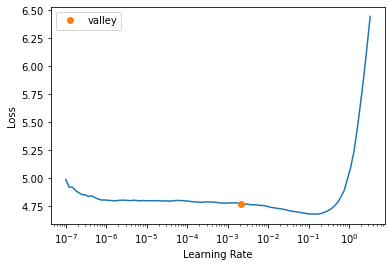

In [117]:
learn.lr_find()

In [126]:
lr = 0.001
learn.fine_tune(1, lr*10)  # moms=(0.8, 0.7) seems not to work. 

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.172253,4.153037,0.282581,63.626945,34:01


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.912453,3.966340,0.299641,52.790939,36:51


In [127]:
save_path = Path(os.getcwd())
learn.save(save_path/"output/fit_1")

Path('/home/fastai2/notebooks/fastai_NLP/output/fit_1.pth')

In [128]:
learn.save_encoder(save_path/"output/fit_1_enc")

In [129]:
enc = learn.model[0].encoder

In [131]:
with torch.no_grad():
    print(
        np.allclose(enc.weight[stoi(vocab, "30-something"), :].cpu(),
                    enc.weight[stoi(vocab, "linklater"), :].cpu())
    )

False


In [132]:
with torch.no_grad():
    print(
        np.allclose(enc.weight[stoi(vocab, "30-something"), :].cpu(),
                    new_word_vec)
    )

False


Generate movie review-like text, with fine-tuned IMDb language model

In [133]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) 
                for _ in range(N_SENTENCES)))

i liked this movie because it was n't bad . It was hard to tell how to make a movie that made me think about how a person could watch a movie . i absolutely loved this movie . i felt like the actors
i liked this movie because i had heard that I 've seen it before , and i have seen this movie several times . Thank you Hollywood for bringing it back time , and this movie is one of the best movies


In [134]:
TEXT = "This movie was"
N_WORDS = 30
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75)
                for _ in range(N_SENTENCES)))

This movie was really good . My wife and i was very excited . It was a very young movie , but i was very disappointed by this movie .
This movie was the first movie i have ever seen , and i must admit that i felt at the time it was very strong . The acting was good and the


In [135]:
TEXT = "I hated this movie"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75)
                for _ in range(N_SENTENCES)))

i hated this movie , and the plot was pretty simple . And it was the script that tried to make a movie like this . As a fan of the genre , i was thinking it was a sequel .
i hated this movie , and i just saw it after the screening of THE KING OF MIRANDA . It was great . All i felt was that this movie had some flaws because it was so bad


### Risk of language models
Computer-generated answers for example, is almost impossible to filter although they make no sense to humans. Example: ML generated answers posted on StackOverflow. Ask Roboflow: generated answers of... questionable correctness. It floods out real useful answers. 

# Building an IMDb Sentiment Classifier. 
We'll use transfer learning to create a `classifier`. 

Because batch size would be crazy again, we would decrease the batch size again. 

In [145]:
torch.cuda.empty_cache()
bs = 48

dls_clas = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid="test", 
                    text_vocab=dls_lm.vocab, bs=bs, num_workers=os.cpu_count())

In [146]:
dls_clas.show_batch()

,text,category
0,"xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules of the match , both opponents have to go through tables in order to get the win . xxmaj benoit and xxmaj guerrero heated up early on by taking turns hammering first xxmaj spike and then xxmaj bubba xxmaj ray . a xxmaj german xxunk by xxmaj benoit to xxmaj bubba took the wind out of the xxmaj dudley brother . xxmaj spike tried to help his brother , but the referee restrained him while xxmaj benoit and xxmaj guerrero",pos
1,"xxbos xxmaj some have praised xxunk xxmaj lost xxmaj xxunk as a xxmaj disney adventure for adults . i do n't think so -- at least not for thinking adults . \n\n xxmaj this script suggests a beginning as a live - action movie , that struck someone as the type of crap you can not sell to adults anymore . xxmaj the "" crack staff "" of many older adventure movies has been done well before , ( think xxmaj the xxmaj dirty xxmaj dozen ) but xxunk represents one of the worse films in that motif . xxmaj the characters are weak . xxmaj even the background that each member trots out seems stock and awkward at best . xxmaj an xxup md / xxmaj medicine xxmaj man , a tomboy mechanic whose father always wanted sons , if we have not at least seen these before ,",neg
2,"xxbos xxmaj director xxmaj douglas xxmaj sirk once said ` there 's a very short distance between high art and trash , and trash that contains craziness is by this very quality nearer to art ' . xxmaj this statement defines his cinema perfectly , a very unique body of work that includes classic stage adaptations , adventure and war films , westerns and of course , his famous melodramas . \n\n xxmaj sirk 's melodramas were , as the very word signifies , dramas with music . xxmaj the music sets the tone for his masterful style , and every stroke of his brush ( sirk was also a painter ) leaves a powerful image on the screen - turned - canvas . xxmaj but this ai n't life but its representation , an imitation of life . xxmaj sirk never tried to show reality , on the contrary",pos
3,"xxbos xxup myra xxup breckinridge is one of those rare films that established its place in film history immediately . xxmaj praise for the film was absolutely nonexistent , even from the people involved in making it . xxmaj this film was loathed from day one . xxmaj while every now and then one will come across some maverick who will praise the film on philosophical grounds ( aggressive feminism or the courage to tackle the issue of xxunk ) , the film has not developed a cult following like some notorious flops do . xxmaj it 's not hailed as a misunderstood masterpiece like xxup scarface , or trotted out to be ridiculed as a camp classic like xxup showgirls . \n\n xxmaj undoubtedly the reason is that the film , though outrageously awful , is not lovable , or even likable . xxup myra xxup breckinridge is just",neg
4,"xxbos xxmaj it is not as great a film as many people believe ( including my late aunt , who said it was her favorite movie ) . xxmaj but due to the better sections of this film noir , particularly that justifiably famous "" fun house "" finale , xxup the xxup lady xxup from xxup shanghai has gained a position of importance beyond it 's actual worth as a key to the saga of xxmaj orson xxmaj welles ' failure to conquer xxmaj hollywood . \n\n xxmaj by 1946 xxmaj welles ' position as a xxmaj hollywood figure was mixed . xxup citizen xxup kane was not recognized as the great movie it has since been seen as due to the way it was attacked by the xxmaj hearst press and by xxmaj hollywood insiders themselves . xxmaj welles ' attempt at total control ( direction and production",po

## Create a model to classify the IMDb reviews and load encoder we saved before. 

In [147]:
# Freeze weights for all but last layer and find good value for learning rate. 
learn_c = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.3, 
                metrics=accuracy).to_fp16()
learn_c.load_encoder(save_path/"output/fit_1_enc")
learn_c.freeze()

SuggestedLRs(valley=tensor(0.0025))

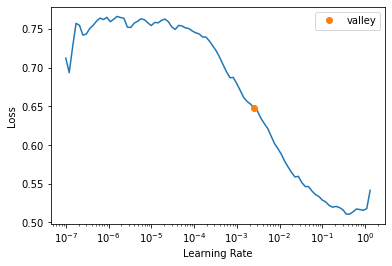

In [148]:
learn_c.lr_find()

### Train and fine tune IMDb sentiment classifier. 
Train one cycle, and save intermediate result. 

In [152]:
learn_c.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.309165,0.277712,0.885520,10:50


In [153]:
save_path = save_path/"output"
learn_c.save(save_path/"textc_first")
learn_c.load(save_path/"textc_first")

Unfreeze last two layers and train for one cycle, save intermediate result. 

In [154]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/2.6**4), 1e-2)  # again, we ignore moms. 

epoch,train_loss,valid_loss,accuracy,time
0,0.291354,0.260479,0.895560,13:00


In [155]:
learn_c.save(save_path/"textc_second")

Path('/home/fastai2/notebooks/fastai_NLP/output/textc_second.pth')

Unfreeze the last three layers, and train for one cycle, and save intermediate result. 
At this point, we've beaten 2017 (pre-transfer learning) state of the art. 

In [156]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4), 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.230004,0.189837,0.927520,22:40


In [157]:
learn_c.save(save_path/"textc_third")
learn_c.load(save_path/"textc_third")

Unfreeze all layers, train for two cycles, and save the result. 

Might encounter: `CUDA error: unspecified launch failure`. Just try to run it again if so. This problem is due to LSTM. 

In [158]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.176315,0.182540,0.930800,25:38
1,0.143560,0.187312,0.928120,25:37


In [159]:
learn_c.save(save_path/"textc_clas")

Path('/home/fastai2/notebooks/fastai_NLP/output/textc_clas.pth')

Let's look and see how it predicts. 

In [160]:
learn_c.predict("I really loved that movie, it was awesome!")

('pos', tensor(1), tensor([1.8520e-06, 1.0000e+00]))

In [161]:
learn_c.predict("I didn't really love that movie, and I didn't think it was awesome.")

('neg', tensor(0), tensor([0.8184, 0.1816]))